In [1]:
import pandas as pd
import numpy as np
from src.preprocessing import load_and_process_data, create_user_sequences, train_test_split_by_user
from src.hmm import HiddenMarkovModel
from src.baselines import TimeOfDayBaseline, FrequencyBaseline, HomeBaseline
from src.utils import LabelEncoder, calculate_accuracy
from src.baselines import TimeOfDayBaseline, FrequencyBaseline,RFBaseline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

**DATA**

In [2]:
data_path = "./data/mode_purpose_hmm.csv" # Adjust path if necessary
df = load_and_process_data(data_path)
user_sequences = create_user_sequences(df)

In [3]:
train_seqs, test_seqs = train_test_split_by_user(user_sequences, test_size=0.2)

In [4]:
# sample entry
print(train_seqs[0])

[('car', 'errand', Timestamp('2021-08-04 19:22:46+0000', tz='UTC')), ('walk', 'home', Timestamp('2021-08-04 21:03:32+0000', tz='UTC')), ('car', 'home', Timestamp('2021-08-04 21:33:50+0000', tz='UTC'))]


In [5]:
# encode data
mode_encoder = LabelEncoder()
purpose_encoder = LabelEncoder()

all_modes = set()
all_purposes = set()

for seq in train_seqs+test_seqs:
    for mode,purpose,_ in seq:
        all_modes.add(mode)
        all_purposes.add(purpose)


In [51]:
mode_encoder.fit(list(all_modes))
purpose_encoder.fit(list(all_purposes))

In [7]:
print(f"Modes: {mode_encoder.classes_}")
print(f"Purposes: {purpose_encoder.classes_}")

Modes: ['bike', 'bus', 'car', 'train', 'walk']
Purposes: ['eat', 'errand', 'home', 'leisure', 'work']


**BASELINE**

***JustHome***

In [32]:
home_baseline = HomeBaseline()

home_true = []
home_pred = []

for seq in test_seqs:
    for _,gt_purpose, timestamp in seq:
        home_true.append(gt_purpose)
        pred = "home"
        home_pred.append(pred)

acc_tod = accuracy_score(home_true, home_pred)
print(f"Home Baseline Accuracy: {acc_tod:.4f}")

Home Baseline Accuracy: 0.3522


***Rule-based***

In [33]:
# rule-based, predict purpose given time of day

tod_baseline = TimeOfDayBaseline()

tod_true = []
tod_pred = []

for seq in test_seqs:
    for _,gt_purpose, timestamp in seq:
        tod_true.append(gt_purpose)
        pred = tod_baseline.predict(timestamp)
        tod_pred.append(pred)

acc_tod = accuracy_score(tod_true, tod_pred)
print(f"TimeOfDay Baseline Accuracy: {acc_tod:.4f}")



TimeOfDay Baseline Accuracy: 0.2092


***Frequency-based***

In [9]:
freq_baseline = FrequencyBaseline()

# get mode and purpose, w/o timestamps
train_seqs_stripped = [[(row[0], row[1]) for row in seq] for seq in train_seqs]

# training
freq_baseline.fit(train_seqs_stripped)

freq_true_flattened = []
freq_pred_flattened = []

# prediction
for seq in test_seqs:
    for row in seq:
        mode, true_purpose, _ = row  
        
        pred_purpose = freq_baseline.predict(mode)
        
        freq_true_flattened.append(true_purpose)
        freq_pred_flattened.append(pred_purpose)

acc_freq = accuracy_score(freq_true_flattened, freq_pred_flattened)
print(f"Frequency Baseline Accuracy: {acc_freq:.4f}")

Frequency Baseline Accuracy: 0.2722


***Random Forest***

In [10]:
def prepare_rf_data(sequences, m_encoder, p_encoder):
    """
    convert (mode,purpose,timestamp) to X= [mode,timestamp], y = [purpose]
    """
    X = []
    y = []
    for seq in sequences: # daily trips 
        for row in seq: # one trip with mode, purpose, time 
            mode, purpose, timestamp = row
            
            # feature 1 :mode of the trip 
            m_idx = m_encoder.transform([mode])[0]
            
            # feature 2: hour of day 
            hour = timestamp.hour
            
            X.append([m_idx, hour])
            
            # gt purpose 
            p_idx = p_encoder.transform([purpose])[0]
            y.append(p_idx)
            
    return np.array(X), np.array(y)

In [11]:
X_train, y_train = prepare_rf_data(train_seqs, mode_encoder, purpose_encoder)
X_test, y_test = prepare_rf_data(test_seqs, mode_encoder, purpose_encoder)

In [19]:
rf_baseline = RFBaseline(n_estimators=300,random_seed=42)
rf_baseline.fit(X_train,y_train)

In [26]:
y_pred = rf_baseline.predict(X_test)
y_test_label = purpose_encoder.inverse_transform(y_test)
y_pred_label = purpose_encoder.inverse_transform(y_pred)

In [27]:
acc_rf = accuracy_score(y_test_label, y_pred_label)
print(f"Random Forest Accuracy: {acc_rf:.4f}")

Random Forest Accuracy: 0.4617


***Standard 1-Gram HMM***

In [28]:
# HMM Model
hmm = HiddenMarkovModel(num_states=len(purpose_encoder), num_observations=len(mode_encoder))

# Train (MLE)
hmm.maximum_likelihood_initialize_parameters(train_seqs, purpose_encoder, mode_encoder)

# Predict (Viterbi)
true_purposes = []
pred_purposes = []

for i, seq in enumerate(test_seqs):
    # Extract modes and purposes
    modes = [row[0] for row in seq]
    purposes = [row[1] for row in seq]
    
    # Encode modes to integers
    obs_seq = mode_encoder.transform(modes)
    
    # Predict
    pred_indices = hmm.predict_viterbi(obs_seq)
    
    # Decode predictions
    pred_labels = purpose_encoder.inverse_transform(pred_indices)
    
    true_purposes.append(purposes)
    pred_purposes.append(pred_labels)
    # print(purposes)
    # print(pred_labels)
    # print("======")
    # if i == 10:
    #     break
    

# Accuracy
acc_hmm = calculate_accuracy(true_purposes, pred_purposes)
print(f"HMM Accuracy: {acc_hmm:.4f}")

HMM Accuracy: 0.3561


While this attempt performs better than the rule-based and frequency-based baselines, it is still not as good as the Random Forest model. Upon observation of some of the predictions/labels, it seems that the HMM model is biased towards state transitions that reach the "home" purpose. This may be fixed with a higher-order HMM model. If not, then we may need to clean the data or make the number of purposes more granular.

***EVALUATION***

In [29]:
def eval_baseline(y_true,y_pred,label_names,title="Confusion Matrix"):

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    _, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()
    pass

***Time of Day Eval***

[[ 1649     0   809   650  1499]
 [ 8660     0  8792  2850 19895]
 [24929     0 16616 13984 29141]
 [16287     0 13269  6307 30814]
 [ 5531     0 11964  1044 25736]]


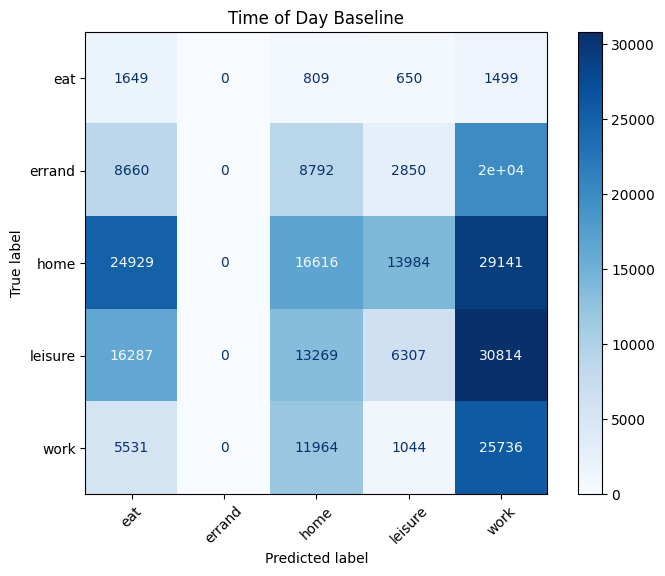

In [34]:
PURPOSE_NAMES = purpose_encoder.classes_
eval_baseline(
    y_true=tod_true,
    y_pred=tod_pred,
    label_names=PURPOSE_NAMES,
    title="Time of Day Baseline"
)


***Frequency-based Eval***

[[  100   791  1570  1328   818]
 [  790  7985 13421 10765  7236]
 [ 1481 13291 30191 23294 16413]
 [ 1291 10774 23280 18540 12792]
 [  707  7301 15612 12018  8637]]


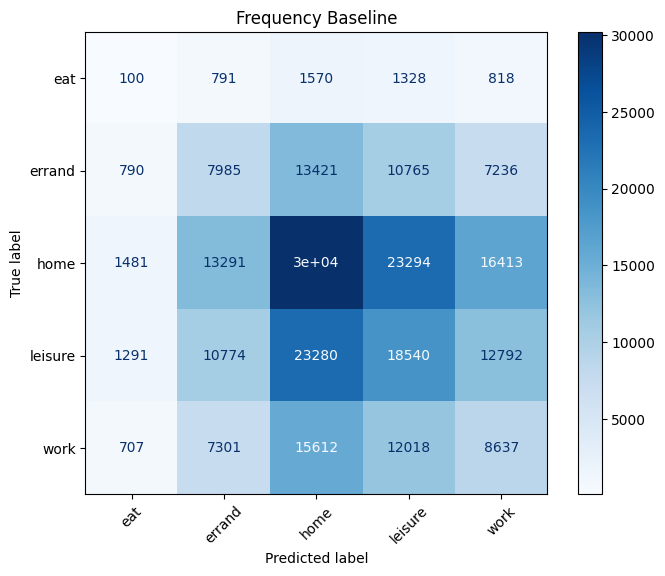

In [35]:
eval_baseline(
    y_true=freq_true_flattened,
    y_pred=freq_pred_flattened,
    label_names=PURPOSE_NAMES,
    title="Frequency Baseline"
)


***Random Forest Eval***

[[    0   208  2227  2055   117]
 [    0  5494 16304 14656  3743]
 [    0  1799 56982 23254  2635]
 [    0  2085 30925 30443  3224]
 [    0  2179  9919 14100 18077]]


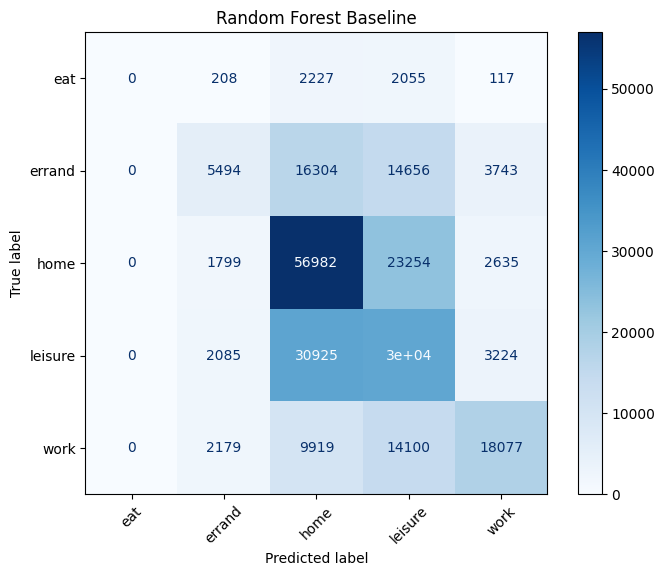

In [37]:
eval_baseline(
    y_true=y_test,
    y_pred=y_pred,
    label_names=PURPOSE_NAMES,
    title="Random Forest Baseline"
)


***HMM Eval***

[[    0   339  1186  2595   487]
 [    0  8321 10542 15475  5859]
 [    0  3102 38119 29834 13615]
 [    0  2849 21945 30842 11041]
 [    0  4269 15433 16242  8331]]


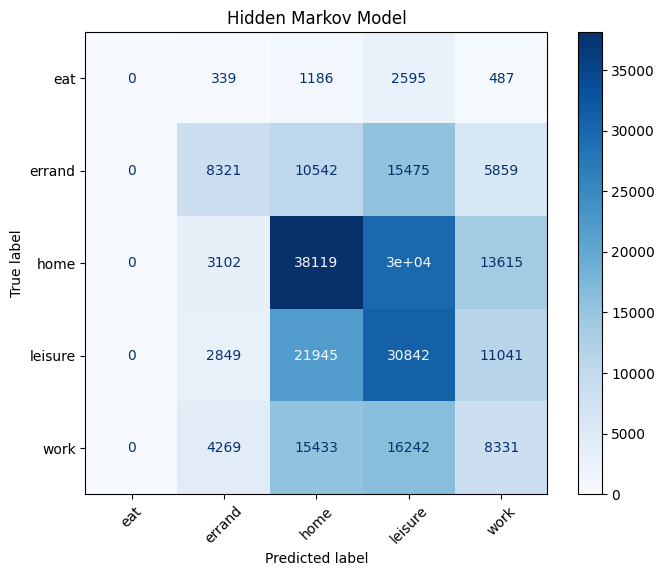

In [71]:
hmm_true = [label for seq in true_purposes for label in seq]
hmm_pred = [label for seq in pred_purposes for label in seq]

eval_baseline(
    y_true=hmm_true,
    y_pred=hmm_pred,
    label_names=PURPOSE_NAMES,
    title="Hidden Markov Model"
)
